In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import gzip
from utility import *
import tensorflow as tf
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/bzr0014/anaconda3/envs/tensorCpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/bzr0014/anaconda3/envs/tensorCpu/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['log', 'colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
pylab.rcParams['figure.figsize'] = (15, 9)
sys.setrecursionlimit(10000)
conv2d1_filters_numbers = 8
conv2d1_filters_size = 9
conv2d2_filters_numbers = 8
conv2d2_filters_size = 1
conv2d3_filters_numbers = 1
conv2d3_filters_size = 5

down_sample_ratio = 16
learning_rate = 0.00001
epochs = 10
HiC_max_value = 100

In [9]:
low_resolution_samples = np.load(gzip.GzipFile('../data/GM12878_replicate_down16_chr19_22.npy.gz', "r")) * down_sample_ratio
high_resolution_samples = np.load(gzip.GzipFile('../data/GM12878_replicate_original_chr19_22.npy.gz', "r"))
low_resolution_samples_val = np.load(gzip.GzipFile('../data/GM12878_replicate_down16_chr17_17.npy.gz', "r")) * down_sample_ratio
N, d, w, h = low_resolution_samples.shape
low_resolution_samples = low_resolution_samples[:, 0, :, :].reshape(N, w, h, d)
high_resolution_samples = high_resolution_samples[:, 0, :, :].reshape(N, w, h, d)
#low_resolution_samples, high_resolution_samples, cache = loadData(40, 40, 23, 23, root="../../")
#low_resolution_samples = low_resolution_samples.reshape(-1, 40, 40, 1)
#high_resolution_samples = high_resolution_samples.reshape(-1, 40, 40, 1)


In [10]:
print(low_resolution_samples.shape)
print(high_resolution_samples.shape)

(14689, 40, 40, 1)
(14689, 40, 40, 1)


In [11]:
sample_size = low_resolution_samples.shape[-2]
padding = conv2d1_filters_size + conv2d2_filters_size + conv2d3_filters_size - 3
half_padding = padding // 2
output_length = sample_size - padding

print("Sample Size: %d"%(sample_size))
print("Padding: %d"%(padding))
print("Half Padding: %d"%(half_padding))
print("Output Length: %d"%(output_length))

Sample Size: 40
Padding: 12
Half Padding: 6
Output Length: 28


In [12]:
trainSize = 2000
Y_train = high_resolution_samples[:trainSize, half_padding:(sample_size-half_padding), half_padding:(sample_size-half_padding), 0]
Y_train = Y_train.reshape(Y_train.shape[0], -2)
X_train = low_resolution_samples[:trainSize]

Y_val = high_resolution_samples[trainSize:, half_padding:(sample_size-half_padding), half_padding:(sample_size-half_padding), 0]
Y_val = Y_val.reshape(Y_val.shape[0], -2)
X_val = low_resolution_samples[trainSize:]

In [13]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(2000, 40, 40, 1)
(2000, 784)
(12689, 40, 40, 1)
(12689, 784)


In [14]:
tf.reset_default_graph()

Xtf = tf.placeholder(tf.float32, [None, sample_size, sample_size, 1])
ytf = tf.placeholder(tf.float32, [None, Y_train.shape[1]])
is_training = tf.placeholder(tf.bool)

def myModel(X):
    Wconv1 = tf.get_variable("Wconv1", [conv2d1_filters_size, conv2d1_filters_size, 1, conv2d1_filters_numbers])
    bconv1 = tf.get_variable("bconv1", [conv2d1_filters_numbers])
    Wconv2 = tf.get_variable("Wconv2", [conv2d2_filters_size, conv2d2_filters_size, conv2d1_filters_numbers, conv2d2_filters_numbers])
    bconv2 = tf.get_variable("bconv2", [conv2d2_filters_numbers])
    Wconv3 = tf.get_variable("Wconv3", [conv2d3_filters_size, conv2d3_filters_size, conv2d2_filters_numbers, conv2d3_filters_numbers])
    bconv3 = tf.get_variable("bconv3", [conv2d3_filters_numbers])
    
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1, 1, 1, 1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    a2 = tf.nn.conv2d(h1, Wconv2, strides=[1, 1, 1, 1], padding='VALID')+ bconv2 
    h2 = tf.nn.relu(a2)
    a3 = tf.nn.conv2d(h2, Wconv3, strides=[1, 1, 1, 1], padding='VALID')+ bconv3 
    h3 = tf.nn.relu(a3)
    
    y_out = tf.reshape(h3, [-1, output_length*output_length])
    return y_out

y_out = myModel(Xtf)

total_loss = tf.losses.mean_squared_error(y_out, ytf)
mean_loss = tf.reduce_mean(total_loss)

optimizer = tf.train.AdamOptimizer(1e-5)
train_step = optimizer.minimize(mean_loss)

Training
Iteration 0: with minibatch training loss = 5.77e+03
2
Epoch 1, Overall loss = 5.45e+03


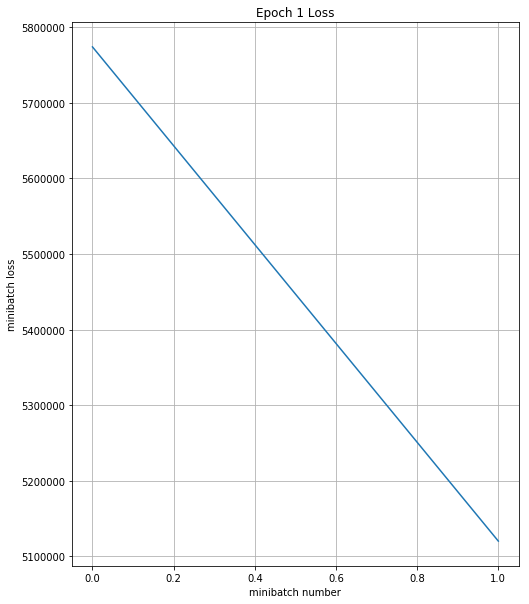

2
Epoch 2, Overall loss = 5.45e+03


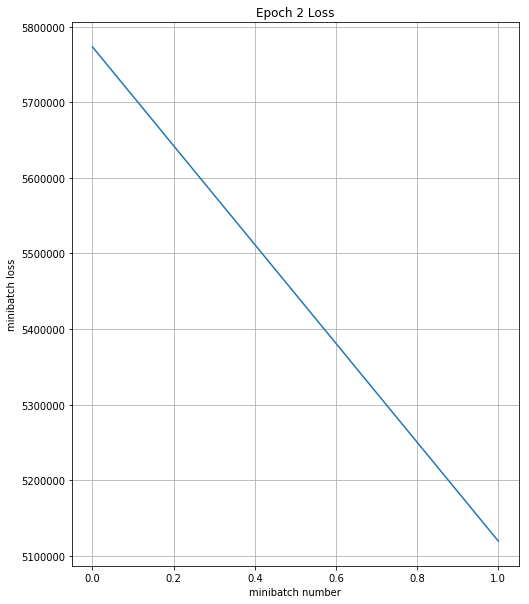

2
Epoch 3, Overall loss = 5.45e+03


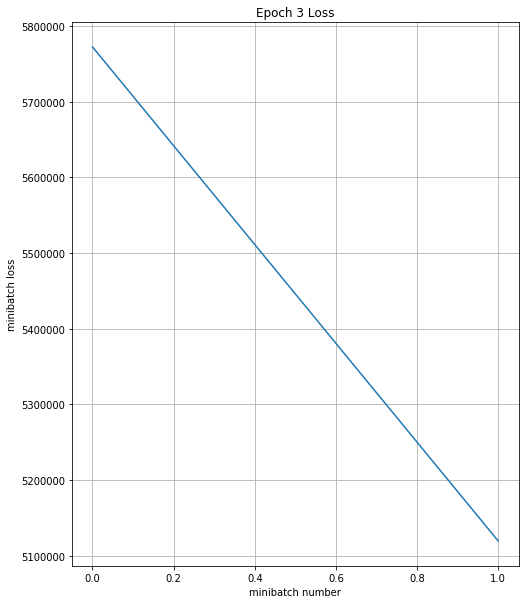

2
Epoch 4, Overall loss = 5.45e+03


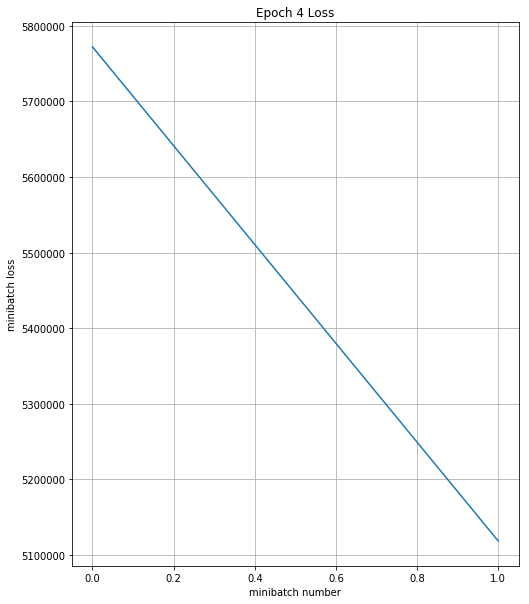

2
Epoch 5, Overall loss = 5.44e+03


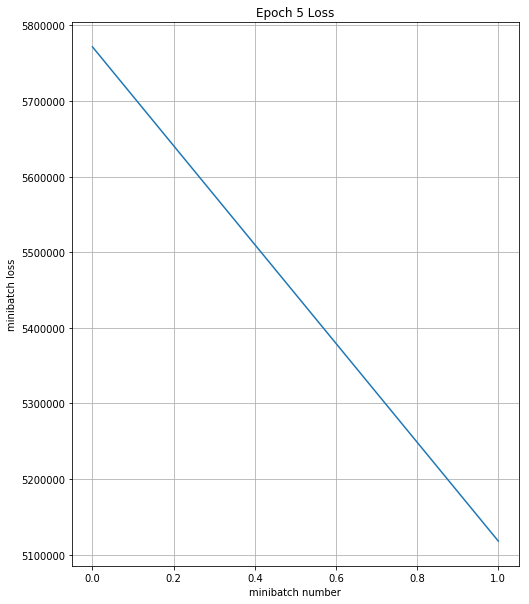

Validation
6211.7627
13
Epoch 1, Overall loss = 5.28e+03


In [15]:
pylab.rcParams['figure.figsize'] = (8, 10)
def run_model(session, predict, loss_val, Xd, yd,
              epochs=2, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss, predict]
    if training_now:
        variables[-1] = training
    # counter 
    iter_cnt = 0
    predictedYs = []
    for e in range(epochs):
        # keep track of losses and accuracy
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {Xtf: Xd[idx,:],
                         ytf: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, yOut = session.run(variables,feed_dict=feed_dict)
            predictedYs.append(yOut)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g}"\
                      .format(iter_cnt,loss))
            elif (iter_cnt % print_every) == 0:
                print(np.mean((yOut - yd[idx])**2))
            iter_cnt += 1
        print(len(losses))
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {1}, Overall loss = {0:.3g}"\
              .format(total_loss,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss, predictedYs

with tf.Session() as sess:
    with tf.device("/cpu:0"):
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train, Y_train, epochs=5, batch_size=1000, print_every=100, \
                  training=train_step,plot_losses=True)
        print('Validation')
        total_loss, predictedYs = run_model(sess,y_out, mean_loss, X_val, Y_val, 1, 1000)

In [ ]:
print(predictedYs.shape)

In [60]:
np.sqrt(14689)

121.19818480488888